# RAG 구조

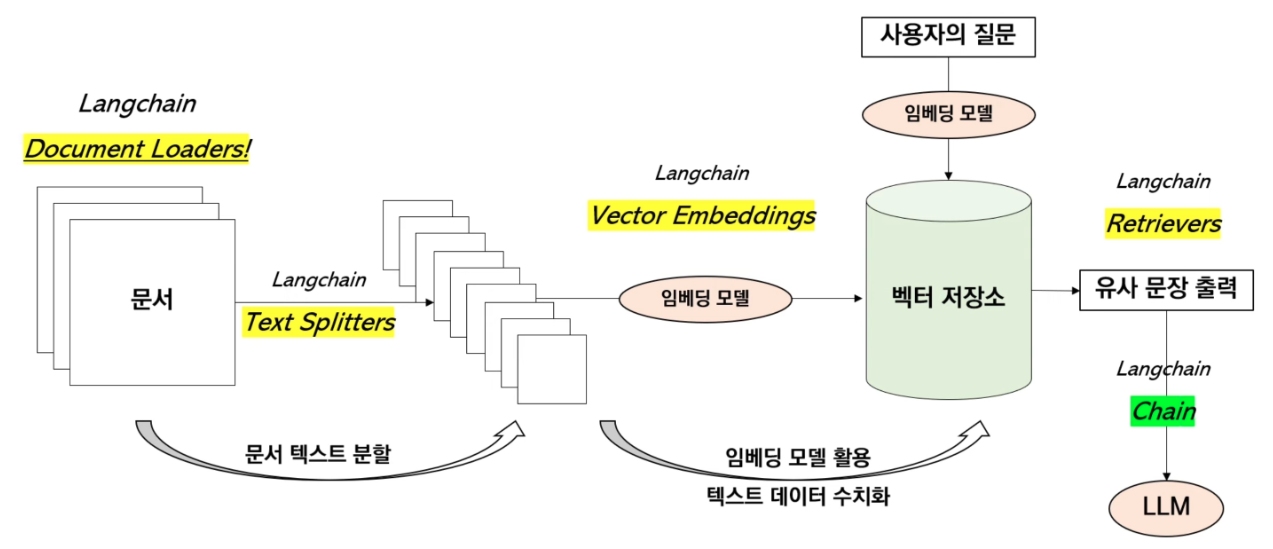

## Text Splitter

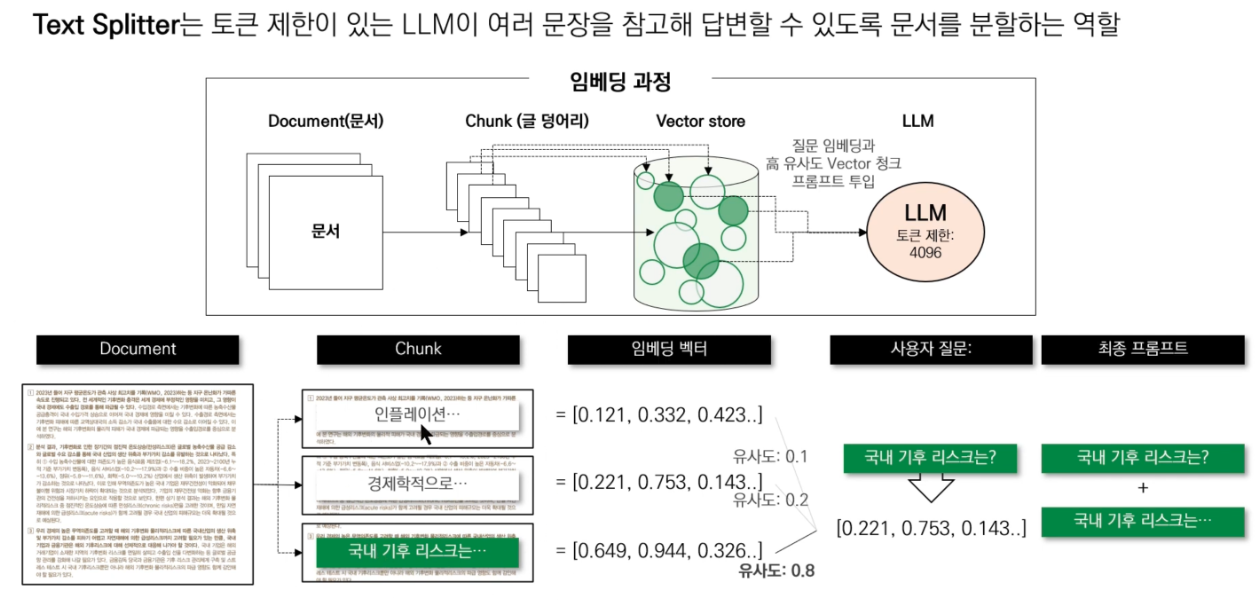

> LangChain은 긴 문서를 작은 단위인 청크(chunk)로 나누는 텍스트 분리 도구를 다양하게 지원합니다. 텍스트를 분리하는 작업을 청킹(chunking)이라고 부르기도 합니다. 이렇게 문서를 작은 조각으로 나누는 이유는 LLM 모델의 입력 토큰의 개수가 정해져 있기 때문입니다. 허용 한도를 넘는 텍스트는 모델에서 입력으로 처리할 수 없게 되는 것입니다. 한편, 텍스트가 너무 긴 경우에는 핵심 정보 이외에 불필요한 정보들이 많이 포함될 수 있어서 RAG 품질이 낮아지는 요인이 될 수도 있습니다. 핵심 정보가 유지될 수 있는 적절한 크기로 나누는 것이 매우 중요합니다.

LangChain이 지원하는 다양한 텍스트 분리기(Text Splitter)는 분할하려는 텍스트 유형과 사용 사례에 맞춰 선택할 수 있는 다양한 옵션이 제공됩니다. 크게 두 가지 차원에서 검토가 필요합니다.

1. `텍스트가 어떻게 분리되는지`:
  - 텍스트를 나눌 때 각 청크가 독립적으로 의미를 갖도록 나눠야 합니다. 이를 위해 문장, 구절, 단락 등 문서 구조를 기준으로 나눌 수 있습니다.

2. `청크 크기가 어떻게 측정되는지`:
  - 각 청크의 크기를 직접 조정할 수 있습니다. LLM 모델의 입력 크기와 비용 등을 종합적으로 고려하여 애플리케이션에 적합한 최적 크기를 결정하는 기준입니다. 예를 들면 단어 수, 문자 수 등을 기준으로 나눌 수 있습니다.

## 분할의 필요성
- `핀포인트 정보 검색(정확성)`: 문서를 세분화함으로써 질문(Query) 에 연관성이 있는 정보만 가져오는데 도움이 됩니다. 각각의 단위는 특정 주제나 내용에 초점을 맞추므로, 관련성이 높은 정보를 제공합니다.
- `리소스 최적화(효율성)`: 전체 문서를 LLM 으로 입력하게 되면 비용이 많이 발생할 뿐더러, 효율적인 답변을 많은 정보속에 발췌하여 답변하지 못하게 됩니다. 때로는 이러한 문제가 할루시네이션으로 이어지게 됩니다. 따라서, 답변에 필요한 정보만 발췌하기 위한 목적도 있습니다.

## 문서분할 과정
1. `문서 구조 파악`: PDF 파일, 웹 페이지, 전자 책 등 다양한 형식의 문서에서 구조를 파악합니다. 이는 문서의 헤더, 푸터, 페이지 번호, 섹션 제목 등을 식별하는 과정을 포함할 수 있습니다.
2. `단위 선정`: 문서를 어떤 단위로 나눌지 결정합니다. 이는 페이지별, 섹션별, 또는 문단별일 수 있으며, 문서의 내용과 목적에 따라 다릅니다.
3. `단위 크기 선정(chunk size)`: 문서를 몇 개의 토큰 단위로 나눌 것인지를 정합니다.
4. `청크 오버랩(chunk overlap)`: 분할된 끝 부분에서 맥락이 이어질 수 있도록 일부를 겹쳐서(overlap) 분할하는 것이 일반적입니다.

# Setup

## 구글 드라이브 연결

In [1]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/ai_lecture/3. Large Language Models/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


## OpenAI Key 등록
- [OpenAI Key 발급](https://platform.openai.com/api-keys)
- [OpenAI 요금](https://openai.com/api/pricing/)

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = ''

## install

In [7]:
!pip install -qU langchain_community langchain-text-splitters tiktoken langchain_experimental langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00


# [CharacterTextSplitter](https://python.langchain.com/docs/how_to/character_text_splitter/)

## 사용방법

CharacterTextSplitter를 사용하여 텍스트를 청크(chunk)로 분할하는 코드입니다.
- `separator` 매개변수로 분할할 기준을 설정합니다. 기본 값은 "\n\n" 입니다.
- `chunk_size` 매개변수를 250 으로 설정하여 각 청크의 최대 크기를 250자로 제한합니다.
- `chunk_overlap` 매개변수를 50으로 설정하여 인접한 청크 간에 50자의 중복을 허용합니다.
- `length_function` 매개변수를 len으로 설정하여 텍스트의 길이를 계산하는 함수를 지정합니다.
- `is_separator_regex` 매개변수를 False로 설정하여 separator를 정규식이 아닌 일반 문자열로 처리합니다.

In [3]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    # 텍스트를 분할할 때 사용할 구분자를 지정합니다. 기본값은 "\n\n"입니다.
    separator="\n\n",
    # 분할된 텍스트 청크의 최대 크기를 지정합니다.
    chunk_size=250,
    # 분할된 텍스트 청크 간의 중복되는 문자 수를 지정합니다.
    chunk_overlap=50,
    # 텍스트의 길이를 계산하는 함수를 지정합니다.
    length_function=len,
    # 구분자가 정규식인지 여부를 지정합니다.
    is_separator_regex=False,
)

## 주의사항
- 우선, 문서를 `\n\n`으로 `split`을 한다.
- `split 문서`가 `chunk_size`가 넘지 않으면 합쳐진다.
- `chunk_size`가 아무리 작아도 `\n\n`으로 짜른 단위가 `최소 chunk`가 된다.
- `chunk_overlap`의 기준은 글자 단위가 아니라 `\n\n`으로 짜른 문단 기준이 된다.

## [with Open()](https://wikidocs.net/233998)

### Load Data

In [4]:
# data/appendix-keywords.txt 파일을 열어서 f라는 파일 객체를 생성합니다.
with open(DATA_PATH+'appendix-keywords.txt') as f:
    file = f.read()  # 파일의 내용을 읽어서 file 변수에 저장합니다.


In [5]:
# 파일으로부터 읽은 내용을 일부 출력합니다.
print(file[:500])

Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding

정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.
예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.
연관키워드: 자연어 처리, 벡터화, 딥러닝

Token

정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.
예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.
연관키워드: 토큰화, 자연어


### split_text()
- split_text() 메서드를 사용하여 텍스트를 분할합니다.

In [6]:
splited_file = text_splitter.split_text(file)
len(splited_file)

30

In [7]:
splited_file[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding'

### create_documents()
- text_splitter를 사용하여 file 텍스트를 문서 단위로 분할합니다.

In [8]:
# text_splitter를 사용하여 state_of_the_union 텍스트를 문서로 분할합니다.
texts = text_splitter.create_documents([file])

In [9]:
len(texts)

30

In [10]:
texts[0]

Document(metadata={}, page_content='Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding')

In [11]:
texts[0].metadata # metadata 정보가 없다.

{}

In [12]:
len(texts[0].page_content) # chunk_size=250 보다 크기가 작다.

197

In [13]:
print(texts[0].page_content)  # 분할된 문서 중 첫 번째 문서를 출력합니다.

Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding


In [14]:
print(texts[1].page_content) # chunk_overlap=50 만큼 데이터가 중복되어 있다.

Embedding

정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.
예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.
연관키워드: 자연어 처리, 벡터화, 딥러닝

Token


- create_documents 메서드는 텍스트 데이터와 메타데이터 리스트를 인자로 받을 수 있습니다.

In [15]:
metadatas = [
    {"document": 1},
]  # 문서에 대한 메타데이터 리스트를 정의합니다.
documents = text_splitter.create_documents(
    [
        file,
    ],  # 분할할 텍스트 데이터를 리스트로 전달합니다.
    metadatas=metadatas,  # 각 문서에 해당하는 메타데이터를 전달합니다.
)

len(documents)

30

In [16]:
documents[0]

Document(metadata={'document': 1}, page_content='Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding')

In [17]:
documents[0].metadata

{'document': 1}

In [18]:
print(documents[0].page_content)

Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding


## [with TextLoader()](https://wikidocs.net/231568)

### Load Data

- `TextLoader` 클래스는 특정 파일에서 텍스트를 로드해서 `Document` 객체로 변환합니다.

In [19]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(DATA_PATH+'appendix-keywords.txt')
data = loader.load()

len(data)

1

In [20]:
data[0].metadata

{'source': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/appendix-keywords.txt'}

In [21]:
data[0].page_content

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.\n예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.\n연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다

### split_documents()

In [22]:
docs = text_splitter.split_documents(data)

len(docs)

30

In [23]:
docs[0]

Document(metadata={'source': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/appendix-keywords.txt'}, page_content='Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding')

# [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- RecursiveCharacterTextSplitter는 CharacterTextSplitter보다 한 단계 더 발전된 방식으로, 텍스트를 보다 유연하게 분할한다.
- 이 도구는 단순히 구분자 하나로 텍스트를 분리하는 것이 아니라, 여러 레벨의 구분자를 정의하여 점진적으로 텍스트를 나누는 방식이다.
- 텍스트가 설정한 최대 길이를 초과할 경우 더 작은 단위로 나눌 수 있도록 설계되었다.

### 특징
- `다중 구분자 사용`: 여러 구분자를 사용하여 텍스트를 재귀적으로 나눈다.
  - 예를 들어, 먼저 문단 단위로 나눈 뒤, 문장이 길면 문장 단위로, 문장이 여전히 길면 단어 단위로 나누는 방식이다.
- `최적의 분할 지점 탐색`: 텍스트의 길이가 설정한 제한을 넘는 경우, 적절한 분할 지점을 찾기 위해 더 작은 단위로 재귀적으로 분할한다.
  - 이렇게 함으로써 문맥을 최대한 유지하면서 텍스트를 효율적으로 분할할 수 있다.
- `더 나은 문맥 보존`: 다양한 구분자를 사용해 텍스트를 나누므로, 단순히 첫 번째 구분자로만 텍스트를 분리하는 것보다 문맥을 더 잘 유지할 수 있다.

## 언제 사용해야 할까?


CharacterTextSplitter를 사용해야 할 때:
- `간단한 작업`: 텍스트가 비교적 짧고, 특정 구분자(예: 줄바꿈)로만 나누어도 충분한 경우.
- `빠르고 직관적인 분할이 필요할 때`: 구분자 하나로도 텍스트를 적절히 나눌 수 있을 때 유용하다.

RecursiveCharacterTextSplitter를 사용해야 할 때:
- `긴 텍스트를 다룰 때`: 문단이나 문장 단위로 텍스트를 나누되, 텍스트의 길이가 제한을 초과하지 않도록 해야 할 때.
- `문맥을 유지하고 싶을 때`: 문맥을 최대한 보존하면서 텍스트를 분할해야 할 경우 적합하다.
- `복잡한 텍스트 구조`: 여러 구분자를 사용해 텍스트를 세밀하게 나누고자 할 때.

## 분할방식
- 분할기는 청크가 충분히 작아질 때까지 주어진 문자 목록의 순서대로 텍스트를 분할하려고 시도합니다.
- 기본 문자 목록은 `["\n\n", "\n", " ", ""]`입니다.
  - `단락` -> `문장` -> `단어` 순서로 재귀적으로 분할합니다.
- 이는 단락(그 다음으로 문장, 단어) 단위가 의미적으로 가장 강하게 연관된 텍스트 조각으로 간주되므로, 가능한 한 함께 유지하려는 효과가 있습니다.
  - `텍스트가 분할되는 방식`: 문자 목록(["\n\n", "\n", " ", ""]) 에 의해 분할됩니다.
  - `청크 크기가 측정되는 방식`: 문자 수에 의해 측정됩니다.

분할방식 순서
1. 우선 `\n\n`기준으로 문서를 `split`한다.
2. `split`한 문장이 `chunk_size`보다 크면 `\n`기준으로 짜른다.
3. `\n`기준으로 짤린 문장이 `chunk_size`보다 크면 `" "` 기준으로 짜른다.
4. `" "`로 짜른 문장이 `chunk_size`보다 크면 `""`기준으로 짜른다.

즉, `separator` 기준으로 `chunk_size`보다 작을 때 까지 계속 짜른다.

## 사용방법

RecursiveCharacterTextSplitter를 사용하여 텍스트를 작은 청크로 분할하는 예제입니다.
- `chunk_size`를 250 으로 설정하여 각 청크의 크기를 제한합니다.
- `chunk_overlap`을 50 으로 설정하여 인접한 청크 간에 50 개 문자의 중첩을 허용합니다.
- `length_function`으로 len 함수를 사용하여 텍스트의 길이를 계산합니다.
- `is_separator_regex`를 False로 설정하여 구분자로 정규식을 사용하지 않습니다.

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # 청크 크기를 매우 작게 설정합니다. 예시를 위한 설정입니다.
    chunk_size=250,
    # 청크 간의 중복되는 문자 수를 설정합니다.
    chunk_overlap=50,
    # 문자열 길이를 계산하는 함수를 지정합니다.
    length_function=len,
    # 구분자로 정규식을 사용할지 여부를 설정합니다.
    is_separator_regex=False,
)

## [with Open()](https://wikidocs.net/233999)

### Load Data

In [25]:
# data/appendix-keywords.txt 파일을 열어서 f라는 파일 객체를 생성합니다.
with open(DATA_PATH+'appendix-keywords.txt') as f:
    file = f.read()  # 파일의 내용을 읽어서 file 변수에 저장합니다.


In [26]:
# 파일으로부터 읽은 내용을 일부 출력합니다.
print(file[:500])


Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding

정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.
예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.
연관키워드: 자연어 처리, 벡터화, 딥러닝

Token

정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.
예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.
연관키워드: 토큰화, 자연어


### split_text()

In [27]:
splited_file = text_splitter.split_text(file)
len(splited_file)

30

In [28]:
splited_file[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding'

### create_documents()

In [29]:
texts = text_splitter.create_documents([file])
len(texts)

30

In [30]:
texts[0]

Document(metadata={}, page_content='Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding')

In [31]:
metadatas = [
    {"document": 1},
]  # 문서에 대한 메타데이터 리스트를 정의합니다.
documents = text_splitter.create_documents(
    [
        file,
    ],  # 분할할 텍스트 데이터를 리스트로 전달합니다.
    metadatas=metadatas,  # 각 문서에 해당하는 메타데이터를 전달합니다.
)

len(documents)

30

In [32]:
documents[0]

Document(metadata={'document': 1}, page_content='Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding')

## [with TextLoader()](https://wikidocs.net/231569)

### Load Data

In [33]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(DATA_PATH+'appendix-keywords.txt')
data = loader.load()

len(data)

1

In [34]:
data[0].metadata

{'source': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/appendix-keywords.txt'}

In [35]:
data[0].page_content

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.\n예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.\n연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다

### split_documents()

In [36]:
docs = text_splitter.split_documents(data)

len(docs)

30

In [37]:
docs[0]

Document(metadata={'source': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/appendix-keywords.txt'}, page_content='Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding')

# [TokenTextSplitter](https://wikidocs.net/234002)
- 언어 모델에는 토큰 제한이 있습니다. 따라서 토큰 제한을 초과하지 않아야 합니다.
- TokenTextSplitter 는 텍스트를 토큰 수를 기반으로 청크를 생성할 때 유용합니다.

## Load Data

In [38]:
# data/appendix-keywords.txt 파일을 열어서 f라는 파일 객체를 생성합니다.
with open(DATA_PATH+'appendix-keywords.txt') as f:
    file = f.read()  # 파일의 내용을 읽어서 file 변수에 저장합니다.


## [OpenAI - tiktoken](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb)
- OpenAI API의 경우 tiktoken 라이브러리를 통해 해당 모델에서 사용하는 토크나이저를 기준으로 분할할 수 있습니다.
- `encoding_name`는 텍스트를 토큰으로 변환하는 인코딩 방식을 나타냅니다.

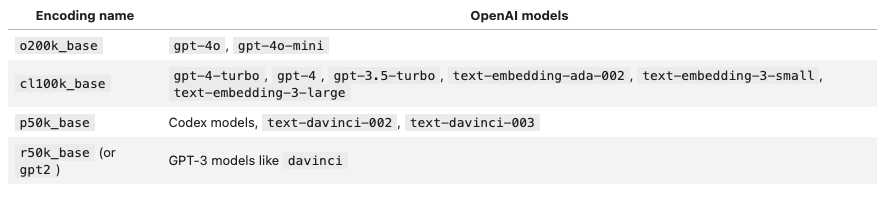

### CharacterTextSplitter
- `CharacterTextSplitter.from_tiktoken_encoder`를 사용하는 경우, 텍스트는 `CharacterTextSplitter`에 의해서만 분할되고 `tiktoken 토크나이저`는 분할된 텍스트를 병합하는 데 사용됩니다.
- 이는 분할된 텍스트가 tiktoken `토크나이저로 측정한 청크 크기보다 클 수 있음`을 의미합니다.

In [41]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=600,
    chunk_overlap=200,
    encoding_name='o200k_base' # OpenAI의 인코딩
)

In [42]:
texts = text_splitter.split_text(file)
len(texts)

7

In [43]:
texts[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.\n예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.\n연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다

### RecursiveCharacterTextSplitter
- `RecursiveCharacterTextSplitter.from_tiktoken_encoder`를 사용하면 분할된 텍스트가 언어 모델에서 허용하는 토큰의 청크 크기보다 크지 않도록 할 수 있으며, 각 분할은 크기가 더 큰 경우 재귀적으로 분할됩니다.
- 또한 tiktoken 분할기를 직접 로드할 수 있으며, 이는 `각 분할이 청크 크기보다 작음을 보장`합니다.

In [44]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=600,
    chunk_overlap=200,
    encoding_name='o200k_base'
)

In [45]:
texts = text_splitter.split_text(file)
len(texts)

7

In [46]:
texts[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.\n예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.\n연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다

### TokenTextSplitter

In [68]:
from langchain_text_splitters import TokenTextSplitter

text_splitter = TokenTextSplitter.from_tiktoken_encoder(
    chunk_size=600,
    chunk_overlap=200,
    encoding_name='o200k_base'
)

In [69]:
texts = text_splitter.split_text(file)
len(texts)

7

In [70]:
texts[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.\n예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.\n연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다

## [Hugginface - tokenizer](https://github.com/teddylee777/Kor-IR?tab=readme-ov-file)
- 한국어 임베딩 모델의 검색 (Information Retrieval) 성능 비교를 위한 리더보드입니다. 현재 Ko-StrategyQA 데이터셋을 사용해 IR 성능을 측정했습니다.

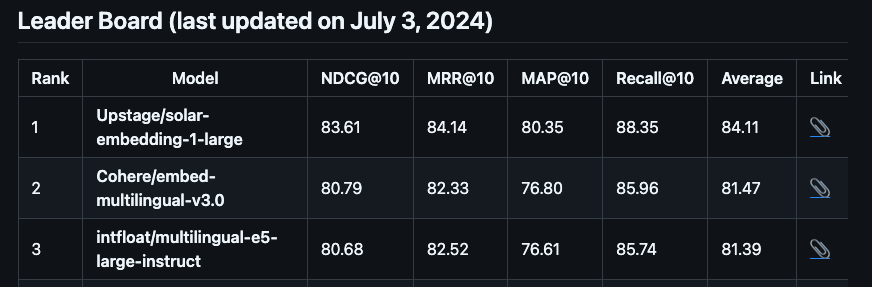

In [50]:
from transformers import AutoTokenizer

model_name = "intfloat/multilingual-e5-large-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

### CharacterTextSplitter

In [59]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size = 600, chunk_overlap = 200)

In [60]:
texts = text_splitter.split_text(file)
len(texts)

7

In [61]:
texts[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.\n예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.\n연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다

### RecursiveCharacterTextSplitter

In [62]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size = 600, chunk_overlap = 200)


In [63]:
texts = text_splitter.split_text(file)
len(texts)

7

In [64]:
texts[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.\n예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.\n연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다

### TokenTextSplitter

In [65]:
from langchain_text_splitters import TokenTextSplitter

# Configure the TextSplitter
text_splitter = TokenTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size = 600, chunk_overlap = 200)


In [66]:
texts = text_splitter.split_text(file)
len(texts)

26

In [67]:
texts[0]

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.'

# [SemanticChunker](https://python.langchain.com/docs/how_to/semantic-chunker/)
- `의미적 유사성에 따라 텍스트를 분할하는 방법`
- 이 방법은 텍스트를 문장 단위로 분할한 후, 3개의 문장씩 그룹화하고, 임베딩 공간에서 유사한 문장들을 병합하는 과정을 거칩니다.

## Load Data

In [3]:
# data/appendix-keywords.txt 파일을 열어서 f라는 파일 객체를 생성합니다.
with open(DATA_PATH+'appendix-keywords.txt') as f:
    file = f.read()  # 파일의 내용을 읽어서 file 변수에 저장합니다.


## Create Text Splitter

In [10]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

text_splitter = SemanticChunker(OpenAIEmbeddings())

## Split Text

In [11]:
docs = text_splitter.create_documents([file])
len(docs)

6

In [12]:
docs[0].page_content

'Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다. 예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다. 연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다. 예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다. 연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다. 예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer\n\n정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다. 예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nVectorStore\n\n정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다. 예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다. 연관키워드: 임베딩, 데이터베이스, 벡터화\n\nSQL\n\n정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다. 예시: SELE

## Breakpoints
- 이 chunker는 문장을 "분리"할 시점을 결정하여 작동합니다. 이는 두 문장 간의 임베딩 차이를 살펴봄으로써 이루어집니다.
- 그 차이가 특정 임계값을 넘으면 문장이 분리됩니다.
- [특정 임계값 분리 참고영상](https://youtu.be/8OJC21T2SL4?si=PzUtNGYJ_KULq3-w&t=2580)

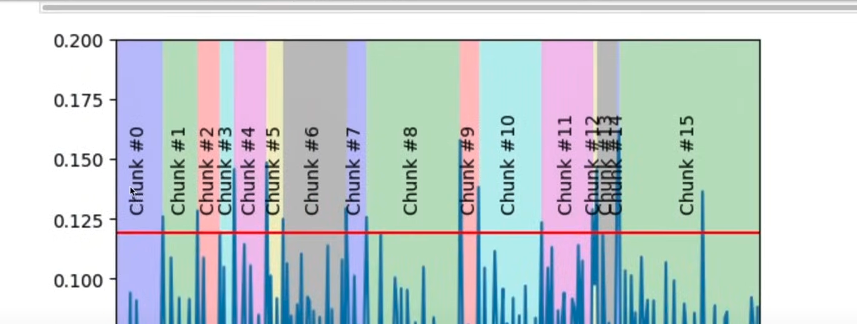

### Percentile
- 기본적인 분리 방식은 백분위수(Percentile) 를 기반으로 합니다.
- 이 방법에서는 문장 간의 모든 차이를 계산한 다음, 지정한 백분위수를 기준으로 분리합니다.

In [13]:
text_splitter = SemanticChunker(
    # OpenAI의 임베딩 모델을 사용하여 시맨틱 청커를 초기화합니다.
    OpenAIEmbeddings(),
    # 분할 기준점 유형을 백분위수로 설정합니다.
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=70,
)


In [14]:
docs = text_splitter.create_documents([file])
for i, doc in enumerate(docs[:5]):
    print(f"[Chunk {i}]", end="\n\n")
    print(doc.page_content)  # 분할된 문서 중 첫 번째 문서의 내용을 출력합니다.
    print("===" * 20)


[Chunk 0]

Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다. 예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다. 연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding

정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.
[Chunk 1]

예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다. 연관키워드: 자연어 처리, 벡터화, 딥러닝

Token

정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.
[Chunk 2]

예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석

Tokenizer

정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.
[Chunk 3]

예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석

VectorStore

정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.
[Chunk 4]

예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다. 연관키워드: 임베딩, 데이터베이스, 벡터화

SQL

정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭

### Standard Deviation
- 이 방법에서는 지정한 `breakpoint_threshold_amount` 표준편차보다 큰 차이가 있는 경우 분할됩니다.
- `breakpoint_threshold_type` 매개변수를 `"standard_deviation"`으로 설정하여 청크 분할 기준을 표준편차 기반으로 지정합니다.

In [15]:
text_splitter = SemanticChunker(
    # OpenAI의 임베딩 모델을 사용하여 시맨틱 청커를 초기화합니다.
    OpenAIEmbeddings(),
    # 분할 기준으로 표준 편차를 사용합니다.
    breakpoint_threshold_type="standard_deviation",
    breakpoint_threshold_amount=1.25,
)


In [16]:
docs = text_splitter.create_documents([file])
for i, doc in enumerate(docs[:5]):
    print(f"[Chunk {i}]", end="\n\n")
    print(doc.page_content)  # 분할된 문서 중 첫 번째 문서의 내용을 출력합니다.
    print("===" * 20)


[Chunk 0]

Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다. 예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다. 연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding

정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다. 예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다. 연관키워드: 자연어 처리, 벡터화, 딥러닝

Token

정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다. 예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석

Tokenizer

정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다. 예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석

VectorStore

정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.
[Chunk 1]

예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다. 연관키워드: 임베딩, 데이터베이스, 벡터화

SQL

정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을 수행할 수 있습니다.
[Chunk 2]

### Interquartile
- 이 방법에서는 사분위수 범위(interquartile range)를 사용하여 청크를 분할합니다.
- `breakpoint_threshold_type` 매개변수를 `"interquartile"`로 설정하여 청크 분할 기준을 사분위수 범위로 지정합니다.

In [17]:
text_splitter = SemanticChunker(
    # OpenAI의 임베딩 모델을 사용하여 의미론적 청크 분할기를 초기화합니다.
    OpenAIEmbeddings(),
    # 분할 기준점 임계값 유형을 사분위수 범위로 설정합니다.
    breakpoint_threshold_type="interquartile",
    breakpoint_threshold_amount=0.5,
)


In [18]:
# text_splitter를 사용하여 분할합니다.
docs = text_splitter.create_documents([file])

# 결과를 출력합니다.
for i, doc in enumerate(docs[:5]):
    print(f"[Chunk {i}]", end="\n\n")
    print(doc.page_content)  # 분할된 문서 중 첫 번째 문서의 내용을 출력합니다.
    print("===" * 20)


[Chunk 0]

Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다. 예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다. 연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding

정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.
[Chunk 1]

예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다. 연관키워드: 자연어 처리, 벡터화, 딥러닝

Token

정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다. 예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석

Tokenizer

정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.
[Chunk 2]

예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다. 연관키워드: 토큰화, 자연어 처리, 구문 분석

VectorStore

정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.
[Chunk 3]

예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다. 연관키워드: 임베딩, 데이터베이스, 벡터화

SQL

정의: SQL(Structured Query Language)은 데이터베이스에서 데이터를 관리하기 위한 프로그래밍 언어입니다. 데이터 조회, 수정, 삽입, 삭제 등 다양한 작업을

# 그외 텍스트 분할
- [코드 분할](https://wikidocs.net/234004)
- [마크다운 분할](https://wikidocs.net/234005)
- [HTML 분할](https://wikidocs.net/234006)
- [JSON 분할](https://wikidocs.net/234007)